In [1]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import math

plt.rcParams['figure.figsize'] = [16, 4]
from plot_utils import *

In [85]:
def plot_mouli_te_variation_with_pval(ax,run_list,pval_list,main_enum,plot_item_list,fname_pattern):
    #Getting the result dict
    result_dict_erm = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_erm.json",
    )
    result_dict_cad = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_cad.json",
    )
    
    
    #Getting the mouli's tv estimate of the TE
    avg_mouli_tv_pred = get_avg_tv_pred(
            run_list=run_list,
            pval_list=pval_list,
            tv_fname_pattern = fname_pattern+"mouli_pred_tv_data.json"
    )
    
    #Plotting the correlation
    correlation_items = ["y-tcausal","y-tconfound","y-tspurious",]
    for corr_item in correlation_items:
        corr_val_mean = np.array([result_dict_erm[pval][corr_item]["mean"] for pval in pval_list])
        corr_val_std = np.array([result_dict_erm[pval][corr_item]["std"] for pval in pval_list])
        ax[0].plot(pval_list,corr_val_mean,ls="-.",marker="o",alpha=0.7)
        ax[0].fill_between(pval_list,corr_val_mean-corr_val_std,corr_val_mean+corr_val_std,alpha=0.3)
        ax[0].set_xlabel("pval")
        ax[0].set_ylim(0.0,1.0)
        ax[0].set_ylabel("topic correlation")
        ax[0].grid(True)  
            
    
    #plotting the avg mouli tv
    tv_pval_var_mean = np.array([avg_mouli_tv_pred[pval]["mean"] for pval in pval_list])
    tv_pval_var_std = np.array([avg_mouli_tv_pred[pval]["std"] for pval in pval_list])
    ax[1].plot(pval_list,tv_pval_var_mean,ls="-.",marker="o",alpha=0.7)
    ax[1].fill_between(pval_list,tv_pval_var_mean-tv_pval_var_std,tv_pval_var_mean+tv_pval_var_std,alpha=0.3)
    ax[1].set_xlabel("pval")
#     ax[1].set_ylim(0.0,1.0)
    ax[1].set_ylabel("|P(Y|phi(X)) - P(Y|X)|")
    ax[1].grid(True)
    
    
    #Plotting the rest the items
    for pidx,plot_item in enumerate(plot_item_list):
        #Plotting the results
        item_yval_erm = np.array([result_dict_erm[pval][plot_item]["mean"] for pval in pval_list])
        yerr_erm = np.array([result_dict_erm[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2].plot(pval_list,item_yval_erm,label="erm",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2].fill_between(pval_list,item_yval_erm-yerr_erm,item_yval_erm+yerr_erm,alpha=0.3)
        
        #Plotting the results
        item_yval_cad = np.array([result_dict_cad[pval][plot_item]["mean"] for pval in pval_list])
        yerr_cad = np.array([result_dict_cad[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2].plot(pval_list,item_yval_cad,label="cad",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2].fill_between(pval_list,item_yval_cad-yerr_cad,item_yval_cad+yerr_cad,alpha=0.3)
        
        
        ax[pidx+2].set_xlabel("pval")
        #ax[pidx+2].set_ylim(-0.3,0.3)
        ax[pidx+2].set_ylabel(plot_item)
        ax[pidx+2].legend()
        ax[pidx+2].grid(True)

In [86]:
def read_tv_json_file(tv_fname):
    with open(tv_fname,"r") as rhandle:
        pred_tv_data = json.load(rhandle)
    return pred_tv_data

def get_avg_tv_pred(run_list,pval_list,tv_fname_pattern):
    avg_tv_pval_dict = defaultdict(dict)
    #Going over the pval
    for pval in pval_list:
        avg_tv_pval_dict[pval]["val_list"]=[]
        #Going over the runs to get the average
        for rnum in run_list:
            pred_tv_data = read_tv_json_file(
                                        tv_fname_pattern.format(pval,rnum)
            )
            avg_tv_pval_dict[pval]["val_list"].append(pred_tv_data["tv_val"])
        #Getting the avarge over the pval
        avg_tv_pval_dict[pval]["mean"]=np.mean(avg_tv_pval_dict[pval]["val_list"])
        avg_tv_pval_dict[pval]["std"]=np.std(avg_tv_pval_dict[pval]["val_list"])
    
    return avg_tv_pval_dict

# First Contact

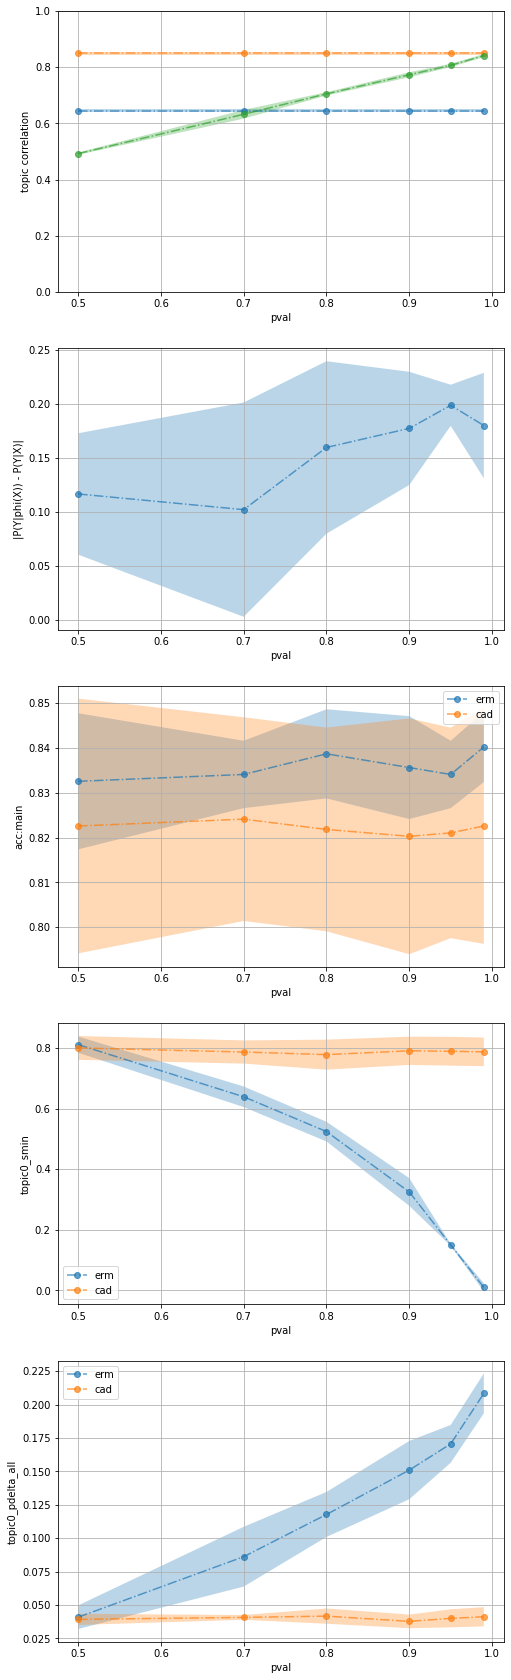

In [88]:
run_list=[0,1,2]
pval_list=[0.5,0.7,0.8,0.9,0.95,0.99]

main_enum=20
topic_name ="spurious"
sample=1000
noise=0.0
mvsel_mode="acc" #acc,loss


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+2,)


plot_mouli_te_variation_with_pval(ax=ax,
                                  run_list=run_list,
                                  pval_list=pval_list,
                                  main_enum=main_enum,
                                  plot_item_list = plot_item_list,
                                  fname_pattern = fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                  ),
)
plt.show()